#  PROJECT TITLE:  

## "Solving Cartpole-v0 with DQN" 


  






 

In [1]:
#https://gym.openai.com/docs/
#https://github.com/zihangdai/pytorch_xworld/blob/master/replay_memory.py
#https://blog.paperspace.com/getting-started-with-openai-gym/
#https://towardsdatascience.com/deep-q-learning-tutorial-mindqn-2a4c855abffc
#https://github.com/fanchenyou/RL-study/blob/master/Part_8.3_IQN_nn.py
#https://medium.com/@aniket.tcdav/deep-q-learning-with-tensorflow-2-686b700c868b
#https://blog.paperspace.com/getting-started-with-openai-gym/
#https://towardsdatascience.com/deep-q-network-dqn-ii-b6bf911b6b2c
#https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch
!pip install pyvirtualdisplay
!apt install xvfb

Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.10).
The following packages were automatically installed and are no longer required:
  cuda-command-line-tools-10-0 cuda-command-line-tools-10-1
  cuda-command-line-tools-11-0 cuda-compiler-10-0 cuda-compiler-10-1
  cuda-compiler-11-0 cuda-cuobjdump-10-0 cuda-cuobjdump-10-1
  cuda-cuobjdump-11-0 cuda-cupti-10-0 cuda-cupti-10-1 cuda-cupti-11-0
  cuda-cupti-dev-11-0 cuda-documentation-10-0 cuda-documentation-10-1
  cuda-documentation-11-0 cuda-documentation-11-1 cuda-gdb-10-0 cuda-gdb-10-1
  cuda-gdb-11-0 cuda-gpu-library-advisor-10-0 cuda-gpu-library-advisor-10-1
  cuda-libraries-10-0 cuda-libraries-10-1 cuda-libraries-11-0
  cuda-memcheck-10-0 cuda-memcheck-10-1 cuda-memcheck-11-0 cuda-nsight-10-0
  cuda-nsight-10-1 cuda-nsight-11-0 cuda-nsight-11-1 cuda-nsight-compute-10-0
  cuda-nsight-compute-10-1 cuda-nsight-compute-11-0 cuda-nsight-c

# Import librabies

In [2]:
import random
import copy
import gym
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
from torch import nn as nn
from torch.optim import AdamW
from tqdm import tqdm
from IPython import display as ipythondisplay
import numpy as np

In [3]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

# show the environment

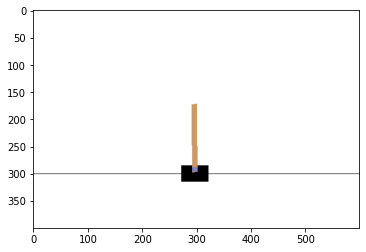

In [4]:
env=gym.make('CartPole-v0')
env.reset()
plt.imshow(env.render(mode='rgb_array'))





# system's characteristics

In [5]:
""""

    | Num | Action                 |
    |-----|------------------------|
    | 0   | Push cart to the left  |
    | 1   | Push cart to the right |

   ### Observation Space
    The observation is a `ndarray` with shape `(4,)` where the elements correspond to the following:
    | Num | Observation           | Min                  | Max                |
    |-----|-----------------------|----------------------|--------------------|
    | 0   | Cart Position         | -4.8*                 | 4.8*                |
    | 1   | Cart Velocity         | -Inf                 | Inf                |
    | 2   | Pole Angle            | ~ -0.418 rad (-24°)** | ~ 0.418 rad (24°)** |
    | 3   | Pole Angular Velocity | -Inf                 | Inf                |

### Episode Termination
    The episode terminates of one of the following occurs:
    1. Pole Angle is more than ±12°
    2. Cart Position is more than ±2.4 (center of the cart reaches the edge of the display)
    3. Episode length is greater than 500 (200 for v0)

 ### Rewards
    Reward is 1 for every step taken, including the termination step. The threshold is 475 for v1.
"""

'"\n\n    | Num | Action                 |\n    |-----|------------------------|\n    | 0   | Push cart to the left  |\n    | 1   | Push cart to the right |\n\n   ### Observation Space\n    The observation is a `ndarray` with shape `(4,)` where the elements correspond to the following:\n    | Num | Observation           | Min                  | Max                |\n    |-----|-----------------------|----------------------|--------------------|\n    | 0   | Cart Position         | -4.8*                 | 4.8*                |\n    | 1   | Cart Velocity         | -Inf                 | Inf                |\n    | 2   | Pole Angle            | ~ -0.418 rad (-24°)** | ~ 0.418 rad (24°)** |\n    | 3   | Pole Angular Velocity | -Inf                 | Inf                |\n\n### Episode Termination\n    The episode terminates of one of the following occurs:\n    1. Pole Angle is more than ±12°\n    2. Cart Position is more than ±2.4 (center of the cart reaches the edge of the display)\n    3

In [6]:
state_dims=env.observation_space.shape[0]
num_actions=env.action_space.n
print('obs_space',env.observation_space)
print('action_space',env.action_space.sample())
print("state dims=",state_dims,"num_actions=",num_actions)

obs_space Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
action_space 1
state dims= 4 num_actions= 2



# gym wrapper

In [7]:
class env_torch(gym.Wrapper):
    
    def __init__(self, env):
        gym.Wrapper.__init__(self, env)
    
    def reset(self):
        state = self.env.reset()
        numpy_to_torch=torch.from_numpy(state)
        convert_shape=torch.unsqueeze(numpy_to_torch,dim=0).float() #change the dimensions and convert it from float64 to float
        return convert_shape
    
    def step(self, action):
        action = action.item()
        next_state, reward, done, info = self.env.step(action)
        convert_numpy_to_torch_next_state=torch.from_numpy(next_state)
        next_state = torch.unsqueeze(convert_numpy_to_torch_next_state,dim=0).float() #change the dimensions and convert it from float64 to float
        
        reward = torch.tensor(reward).view(1, -1).float()
        done = torch.tensor(done).view(1, -1)
        return next_state, reward, done, info

In [8]:
env = env_torch(env)
state = env.reset()
action = torch.tensor(0)
next_state, reward, done, _ = env.step(action)
print("Sample state:", state)
print("Next state:",next_state, "Reward:", reward, "Done:", done)

Sample state: tensor([[-0.0261, -0.0211, -0.0006,  0.0032]])
Next state: tensor([[-0.0265, -0.2162, -0.0005,  0.2957]]) Reward: tensor([[1.]]) Done: tensor([[False]])


# Policy network

In [9]:
q_network=nn.Sequential(              # Initialize network Q with weights θ
    
    nn.Linear(state_dims, 128),
    nn.ReLU(),
    nn.Linear(128,64),
    nn.ReLU(),
    nn.Linear(64,num_actions)
)

# Target network

In [10]:
target_q_network=copy.deepcopy(q_network).eval()  # Initialize target_network with weights= θ

# ε-greedy policy

In [11]:
def policy(state, epsilon):                        # epsilon greedy policy
    if torch.rand(1) < epsilon:                       #exploration
        return torch.randint(num_actions, (1, 1))
    else:
        av = q_network(state).detach()    	          #exploitation
        #print(av)
        #print(torch.argmax(av, dim=-1, keepdim=True))
        return torch.argmax(av, dim=-1, keepdim=True)

# Replay memory

In [12]:
class ReplayMemory:
    
    def __init__(self, capacity=1000000):
        self.capacity = capacity
        self.memory = []  # Initialize memory to Save the transitions
        self.position = 0   # Initialize the position of the saved transitions.

    def push(self, transition):
        """Saves a transition."""
        if self.position >= len(self.memory):
            self.memory.append(transition)
        else:
            self.memory[self.position] = transition
        self.position = (self.position + 1) % self.capacity



    def sample(self, batch_size):

        assert self.can_get_sample(batch_size) # check if it true or false

        batch = random.sample(self.memory, batch_size) # randomly pick elements from the memory
        batch = zip(*batch)     # unpack from the list all the transitions and take each element and group them together(s,a,r,s')
        return [torch.cat(items) for items in batch]

    def can_get_sample(self, batch_size):
        return len(self.memory) >= batch_size 

    def __len__(self):
        return len(self.memory)


# DQN

In [13]:
def dqn(q_network, policy, episodes, alpha=0.0001, batch_size=32, gamma=0.99, epsilon=0.2):
    results={'MSE Loss': [], 'Returns': []}                                     # save MSE LOSS and RETURNS
    optim=AdamW(q_network.parameters(), lr=alpha)  # Set optimizer
    
       
    memory= ReplayMemory()                           
    
             
    
    for episode in tqdm(range(1, episodes +1)):
        state=env.reset()                                                       # Initialize the agent
        done=False
        ep_return=0
        
        while not done:                                                         #While not converged do
            action=policy(state,epsilon)                                        #choose an action a from state s using policy epsilon greedy
            next_state, reward, done, _ =env.step(action)                       #Agent takes action a, observe s',r
            memory.push([state,action, reward,done,next_state])                 #Store transition (s,a,,r,s',done) in the Buffer
            
            if memory.can_get_sample(batch_size):                               # if we have enough expepiences in buffer then
                state_b,action_b,reward_b, done_b, next_state_b=memory.sample(batch_size)   # Sample a random minibatch 
                qsa_b=q_network(state_b).gather(1, action_b)                    # Pass batch of states through the policy network to calculate  batch_Q(s,a)

                next_qsa_b=target_q_network(next_state_b)                       # Pass batch of next_states through the target netowrk to calculate Q'(s',a)
                next_qsa_b=torch.max(next_qsa_b, dim=-1, keepdim=True)[0]       # Calculate the max of batch_Q'(s',a)
                #print(done_b)
                target_b=reward_b + ~(done_b) *gamma*next_qsa_b                 # Calculate the TD_target= reward_batch +gamma*Q'(s',a)
                loss= F.mse_loss(qsa_b, target_b)                               # calculate the Loss function of (Q(s,a),TD_target)
                
                q_network.zero_grad()             
                loss.backward()
                optim.step()       # update the parameters          
                
                results['MSE Loss'].append(loss)
                
            state= next_state
            ep_return+=reward.item()
            
        results['Returns'].append(ep_return)
        
        if episode % 10 == 0:                                                   #update the values of the target network every 10 episodes of the learning
            target_q_network.load_state_dict(q_network.state_dict()) # load the theta values of the policy network(learning) the to target network
    
    return results

# run DQN

In [14]:
results=dqn(q_network,policy,500)

100%|██████████| 500/500 [01:16<00:00,  6.55it/s]


In [15]:
print(len(results["MSE Loss"]))

mse_loss=torch.tensor([results["MSE Loss"]],requires_grad=True)
mse_loss=mse_loss.detach().numpy()
print(mse_loss.shape)
returns=torch.tensor([results["Returns"]],requires_grad=True)
returns=returns.detach().numpy()
print(returns.shape)

37748
(1, 37748)
(1, 500)


# plot mse_loss

(37748, 1)


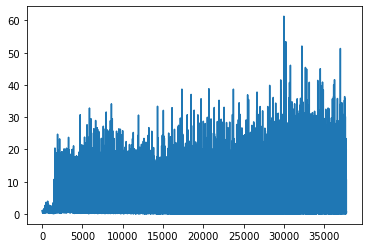

In [16]:
i=np.arange(mse_loss.shape[1])
mse_loss=mse_loss.reshape(mse_loss.shape[1],mse_loss.shape[0])

k=np.arange(returns.shape[1])
returns=returns.reshape(returns.shape[1],returns.shape[0])


print(mse_loss.shape)
plt.plot(i,mse_loss)
plt.show()


# plot returns

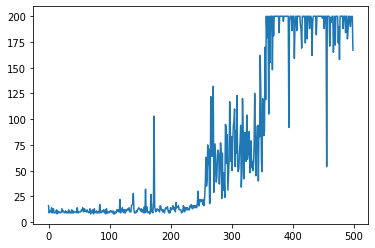

In [17]:
plt.plot(k,returns)
plt.show()

# run the system with random actions

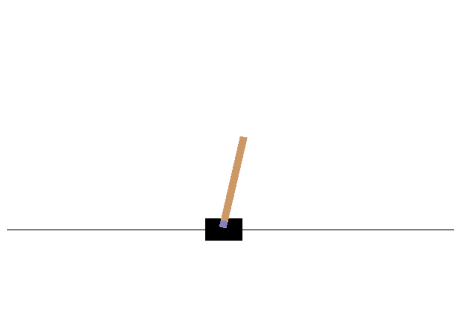

In [18]:
plt.figure(figsize=(8, 8))
env_r=gym.make('CartPole-v0')
for episode in range(3):
  state_r = env_r.reset()
  done_r = False
  img_r = plt.imshow(env_r.render(mode='rgb_array'))
  while not done_r:
    action_random = env_r.action_space.sample()
    next_state_r, _, done_r, _ = env_r.step(action_random)
    img_r.set_data(env_r.render(mode='rgb_array'))
    plt.axis('off')
    ipythondisplay.display(plt.gcf())
    ipythondisplay.clear_output(wait=True)
    state_r = next_state_r

# test the system with policy

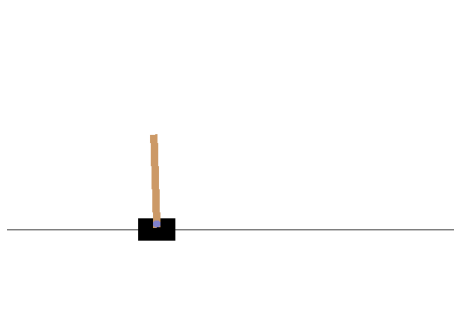

In [19]:
plt.figure(figsize=(8, 8))
for episode in range(2):
  print(episode)
  state = env.reset()
  done = False
  img = plt.imshow(env.render(mode='rgb_array'))
  while not done:
    action = policy(state,0.2)
    next_state, _, done, _ = env.step(action)
    img.set_data(env.render(mode='rgb_array'))
    plt.axis('off')
    ipythondisplay.display(plt.gcf())
    ipythondisplay.clear_output(wait=True)
    state = next_state

